<a href="https://colab.research.google.com/github/zahraa57/Machine-Learning-1-Course-Project/blob/main/modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random as rd
rd.seed(0)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR

In [4]:
data = pd.read_csv('/content/drive/MyDrive/data/data.csv')
features = data.drop(["image_name","pitch","yaw","roll","h","v","t","scale"], axis=1)
labels = data[["pitch","yaw","roll"]]
labels=labels.round(decimals=2)

In [6]:
scaler= MinMaxScaler()
pca=PCA(n_components=6)  

In [7]:
# remark: we fix random_state the end, to make sure we always get the same results
features_train, features_validation_test, labels_train, labels_validation_test = train_test_split(
    features, labels, test_size=0.2, random_state=100)

In [8]:
features_validation, features_test, labels_validation, labels_test = train_test_split(
    features_validation_test, labels_validation_test, test_size=0.1, random_state=100)

In [9]:
svr = MultiOutputRegressor(SVR())
parameters = {'estimator__kernel': ['rbf'], 'estimator__C':[10,20],'estimator__gamma': [1e-7, 1e-10],'estimator__epsilon':[0.1,0.05]}
svr_gs = GridSearchCV(svr, parameters)
svr_gs.fit(features_train,labels_train)
#clf.best_params_
svr_gs.score(features_validation,labels_validation)

-0.0001460831633179153

In [10]:
PIPE_LINE_svr =make_pipeline(scaler,pca,svr_gs).fit(features_train, labels_train)
print(PIPE_LINE_svr.score(features_train, labels_train))
print(PIPE_LINE_svr.score(features_validation,labels_validation))

-0.00034615551665662103
-0.0001848622303829058


In [27]:
x=pd.DataFrame(features_validation.iloc[1]).to_numpy().reshape(1,-1)

In [28]:
x.shape

(1, 936)

In [29]:
PIPE_LINE_svr.predict(x)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


array([[-0.11003383,  0.01989004, -0.01959698]])

In [40]:
%%capture
!pip install mediapipe
#import libraries
import numpy as np
import os,cv2
import scipy.io as sio
import pandas as pd
import mediapipe as mp
import warnings
from matplotlib import pyplot as plt
from math import cos, sin
warnings.filterwarnings('ignore')

In [31]:
x=[]
y=[]
image = cv2.imread("/content/drive/MyDrive/data/images.jpg")
mp_face_mesh=mp.solutions.face_mesh.FaceMesh()
result=mp_face_mesh.process(image)
height,width,_=image.shape 
if result.multi_face_landmarks != None: 
  for facial_landmarks in result.multi_face_landmarks:
    for i in range(0,468):
      pt1=facial_landmarks.landmark[i]
      #print(pt1)
      x.append(pt1.x)
      y.append(pt1.y)
z=pd.DataFrame(np.array([*x,*y]).reshape(1,-1))

In [34]:
y=PIPE_LINE_svr.predict(z)

In [41]:
def draw_axis(img, yaw, pitch, roll, tdx=None, tdy=None, size=50):
    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

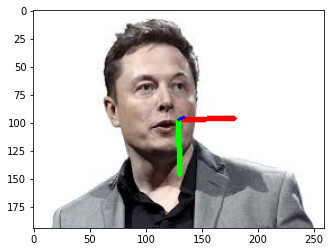

In [43]:
res_img=draw_axis(np.asarray(image),y[0][0],y[0][1],y[0][2])
plt.imshow(cv2.cvtColor(res_img, cv2.COLOR_BGR2RGB))